In [1]:
from torch.autograd import Variable

In [2]:
import PIL
from PIL import Image

import scipy.misc
import numpy as np
from sklearn import cluster
import cv2

In [3]:
from _model import ConvAutoencoder, skip, collect_feature_maps
from _spectral import get_spectral_histogram, apply_lpf
from _cluster import get_cluster_segmentation
from _utils import *

In [4]:
from net import skip, get_noise  # code migratred from DoubleDIP

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Load chosen image 

In [24]:
image_name = 'zebra_paper'

In [45]:
input_path = '/Users/shaharazulay/Downloads/bizon3.jpeg'

img_pil = Image.open(input_path)
img_pil = crop_image_by_multiplier(img_pil, d=32)

img_np = pil_to_np(img_pil)
img_np.shape

(3, 128, 320)

In [44]:
input_path = '../double_dip/images/{}.jpg'.format(image_name)

img_pil = Image.open(input_path)
img_pil = crop_image_by_multiplier(img_pil, d=32)

img_np = pil_to_np(img_pil)
img_np.shape

(3, 192, 288)

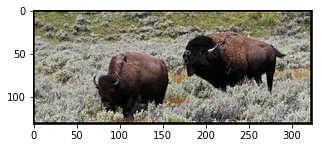

In [46]:
plot_image_grid([img_np], factor=4);

### Load model 

In [47]:
device = 'cpu'

In [48]:
gen_model = lambda: skip(
    2, 3,
    num_channels_down=[8, 16, 32],
    num_channels_up=[8, 16, 32],
    num_channels_skip=[0, 0, 0],
    upsample_mode='bilinear',
    filter_size_down=3,
    filter_size_up=3,
    need_sigmoid=True, need_bias=True, pad='reflection', act_fun='LeakyReLU').to(device)

### Define optimization 

In [49]:
learning_rate = 0.01
mse_loss = nn.L1Loss()

gen_optimizer = lambda: torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate)

### Define noise input 

In [50]:
input_type = 'noise'
input_depth = 2

gen_noise = lambda: get_noise(
        input_depth,
        input_type,
        (img_np.shape[1], img_np.shape[2]))\
    .type(torch.FloatTensor)\
    .detach()

gen_noise().shape

torch.Size([1, 2, 128, 320])

### Train model for several epochs 

In [61]:
num_iter = 50
num_runs_for_stablility = 3

In [62]:
reduce_ = lambda z: {
    k: np.median(np.array([d.get(k) for d in z]), axis=0)
    for k in set().union(*z)
}

In [63]:
X = torch.from_numpy(img_np).unsqueeze(0)
X = Variable(X)

total_recon_curve = []
for run in range(num_runs_for_stablility):
    print(">>> run {} out of {} for stabliltiy".format(run + 1, num_runs_for_stablility))
    noise = gen_noise()
    model = gen_model()
    model.train()
    optimizer = gen_optimizer()
    
    learning_curve = []
    recon_curve = []

    for epoch in range(num_iter):

        X_rec = model(noise)  # inference
    
        loss = mse_loss(X_rec, X)
        learning_curve.append(loss)

        if (epoch + 1) % 10 == 0:
            print("epoch:: {}, LOSS = {}".format(epoch + 1, loss))
            X_rec_np = torch_to_np(X_rec)
            recon_curve.append((epoch + 1, X_rec_np))

        loss.backward()
        optimizer.step()
        model.zero_grad()
    
    total_recon_curve.append(dict(recon_curve))
    
avg_recon_curve = reduce_(total_recon_curve)

>>> run 1 out of 3 for stabliltiy
epoch:: 10, LOSS = 0.13741342723369598
epoch:: 20, LOSS = 0.09854196757078171
epoch:: 30, LOSS = 0.08572876453399658
epoch:: 40, LOSS = 0.08158477395772934
epoch:: 50, LOSS = 0.0793813094496727
>>> run 2 out of 3 for stabliltiy
epoch:: 10, LOSS = 0.12594863772392273
epoch:: 20, LOSS = 0.09339075535535812
epoch:: 30, LOSS = 0.08501383662223816
epoch:: 40, LOSS = 0.08152011036872864
epoch:: 50, LOSS = 0.0792824849486351
>>> run 3 out of 3 for stabliltiy
epoch:: 10, LOSS = 0.13052625954151154
epoch:: 20, LOSS = 0.09670648723840714
epoch:: 30, LOSS = 0.08751009404659271
epoch:: 40, LOSS = 0.08403573930263519
epoch:: 50, LOSS = 0.0818934291601181


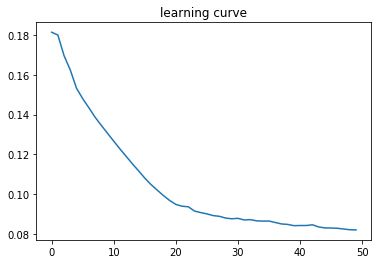

In [64]:
plt.plot(learning_curve);
plt.title('learning curve');

### Visualize reconstruction

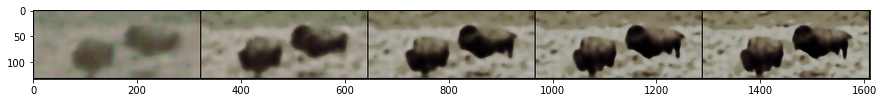

In [66]:
plot_image_grid([avg_recon_curve[k] for k in sorted(avg_recon_curve.keys())], factor=10);

#### Choose final prior 

In [56]:
target_epochs = 50
prior_result = avg_recon_curve[target_epochs]

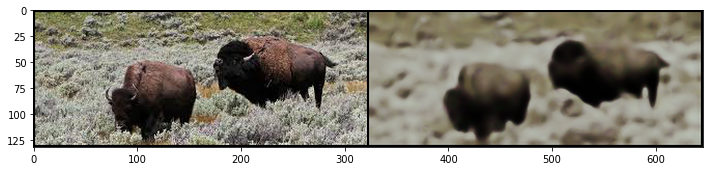

In [57]:
plot_image_grid([torch_to_np(X), prior_result], factor=10);

#### Save a final prior for segmentation 

In [39]:
image = np_to_pil(prior_result)
image.save('../double_dip/priors/{}_prior.jpg'.format(image_name))

#### Save prior change over epochs

In [143]:
# if needed add

#### Spectral Analysis

In [58]:
img_lpf = apply_lpf(img_np)

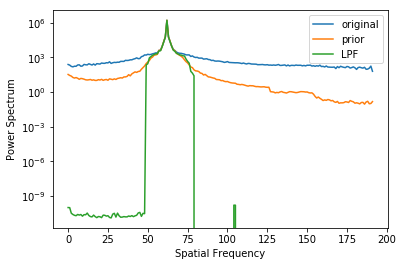

In [59]:
inputs = [img_np, prior_result, img_lpf]

spectral_hist = []
for image in inputs:
    spectral_hist.append(get_spectral_histogram(image))
    

plt.clf()
plt.semilogy(spectral_hist[0])
plt.semilogy(spectral_hist[1])
plt.semilogy(spectral_hist[2])
plt.legend(['original', 'prior', 'LPF'])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power Spectrum')
 
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


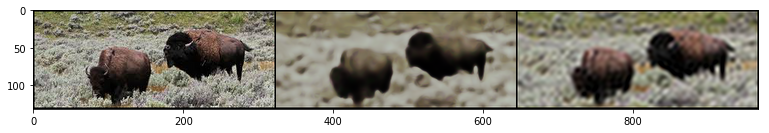

In [60]:
plot_image_grid([torch_to_np(X), prior_result, img_lpf], factor=10);

### Segment the Image (using KMeans)

In [150]:
window_size = 7

In [151]:
inputs = [img_np, prior_result]

cluster_segmentations = []
for image in inputs:
    result = get_cluster_segmentation(image, window_size=window_size, n_clusters=2)
    cluster_segmentations.append(result)

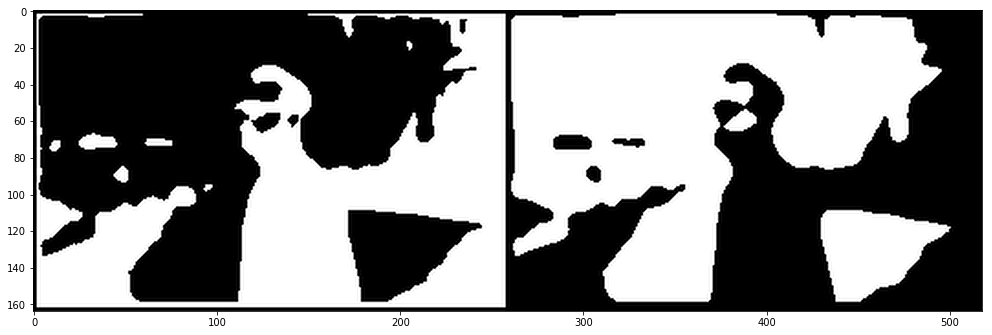

In [152]:
plot_image_grid(cluster_segmentations, factor=15);

In [112]:
image = np_to_pil(cluster_segmentations[-1])
image.save('../double_dip/saliency/output_scaled/{}_cluster_hint.jpg'.format(image_name))